In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Veriyi düzgün şekilde yüklemek için ';' ile ayrılmış olduğunu belirteceğiz
data = pd.read_csv('kecioren.csv', sep=';')

# Sütun isimlerini düzenleyelim
data.columns = ['date', 'PM10', 'PM2.5', 'NO2']

# Tarih sütununu datetime formatına çevirelim
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [3]:
data.head()

,date,PM10,PM2.5,NO2
0,2015-01-01,"17,79","12,06","43,49"
1,2015-01-02,"17,32","7,97","29,08"
2,2015-01-03,"35,45","16,04","39,61"
3,2015-01-04,"28,42","13,5","36,85"
4,2015-01-05,"19,81","10,39","45,49"


In [4]:
data['PM10'] = data['PM10'].str.replace(',', '.').astype(float)
data['PM2.5'] = data['PM2.5'].str.replace(',', '.').astype(float)
data['NO2'] = data['NO2'].str.replace(',', '.').astype(float)

In [5]:
data.set_index('date', inplace=True)

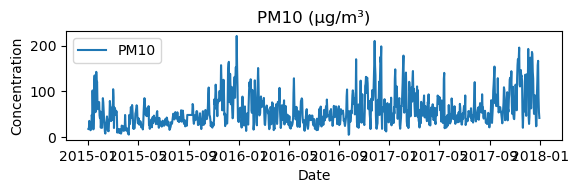

In [6]:
plt.subplot(3, 1, 1)
plt.plot(data.index, data['PM10'], label='PM10')
plt.title('PM10 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()


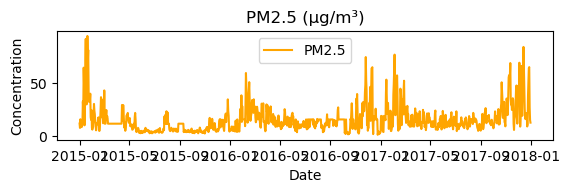

In [7]:
plt.subplot(3, 1, 2)
plt.plot(data.index, data['PM2.5'], label='PM2.5', color='orange')
plt.title('PM2.5 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

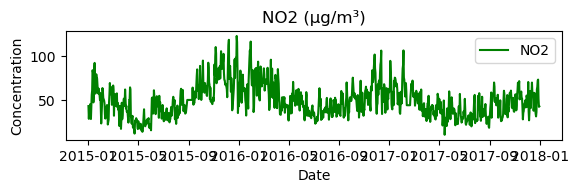

In [8]:
plt.subplot(3, 1, 3)
plt.plot(data.index, data['NO2'], label='NO2', color='green')
plt.title('NO2 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

In [9]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.")

In [10]:
# PM10 için ADF Testi
adf_test(data['PM10'], title='PM10')


Augmented Dickey-Fuller Test: PM10
ADF Test Statistic               -3.738881
p-value                           0.003598
#Lags Used                       19.000000
Number of Observations Used    1076.000000
Critical Value (1%)              -3.436442
Critical Value (5%)              -2.864230
Critical Value (10%)             -2.568202
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [11]:
# PM2.5 için ADF Testi
adf_test(data['PM2.5'], title='PM2.5')

Augmented Dickey-Fuller Test: PM2.5
ADF Test Statistic               -4.534739
p-value                           0.000170
#Lags Used                       13.000000
Number of Observations Used    1082.000000
Critical Value (1%)              -3.436408
Critical Value (5%)              -2.864215
Critical Value (10%)             -2.568194
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [12]:
# NO2 için ADF Testi
adf_test(data['NO2'], title='NO2')

Augmented Dickey-Fuller Test: NO2
ADF Test Statistic               -3.167641
p-value                           0.021936
#Lags Used                       13.000000
Number of Observations Used    1082.000000
Critical Value (1%)              -3.436408
Critical Value (5%)              -2.864215
Critical Value (10%)             -2.568194
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [13]:
def plot_acf_pacf(series, lags=50):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    # ACF grafiği
    plot_acf(series, lags=lags, ax=ax[0])
    ax[0].set_title('ACF')

    # PACF grafiği
    plot_pacf(series, lags=lags, ax=ax[1])
    ax[1].set_title('PACF')

    plt.show()

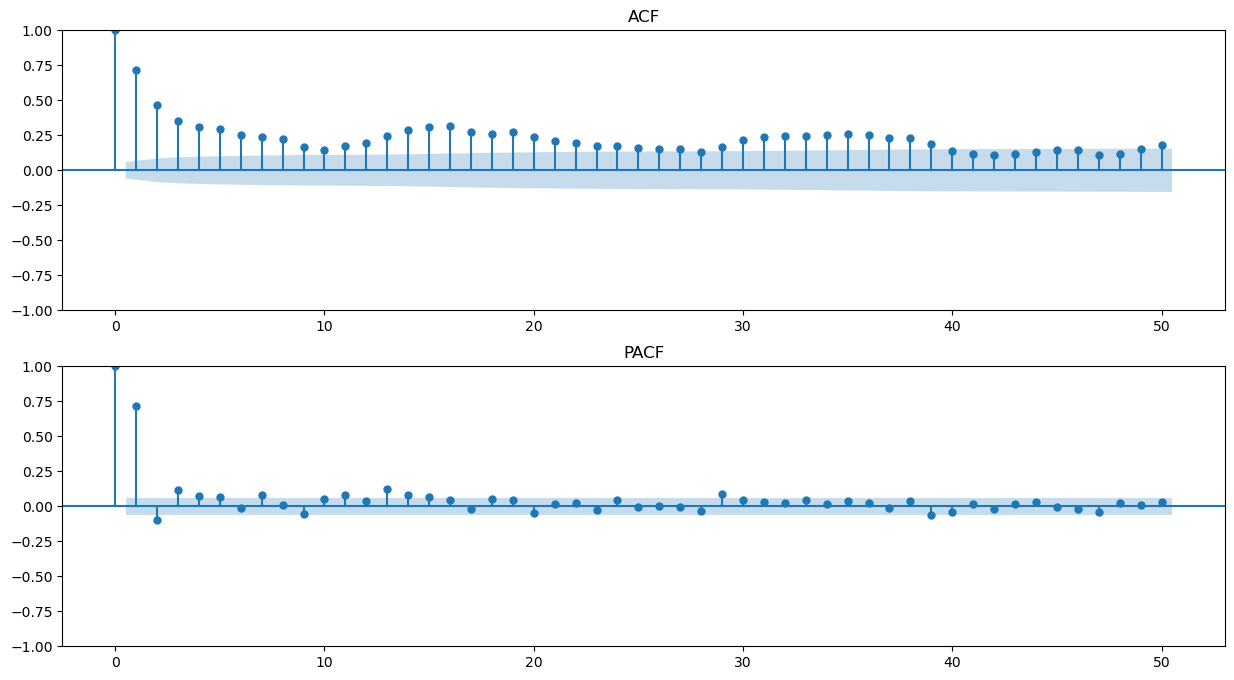

In [14]:
plot_acf_pacf(data['PM10'].dropna())

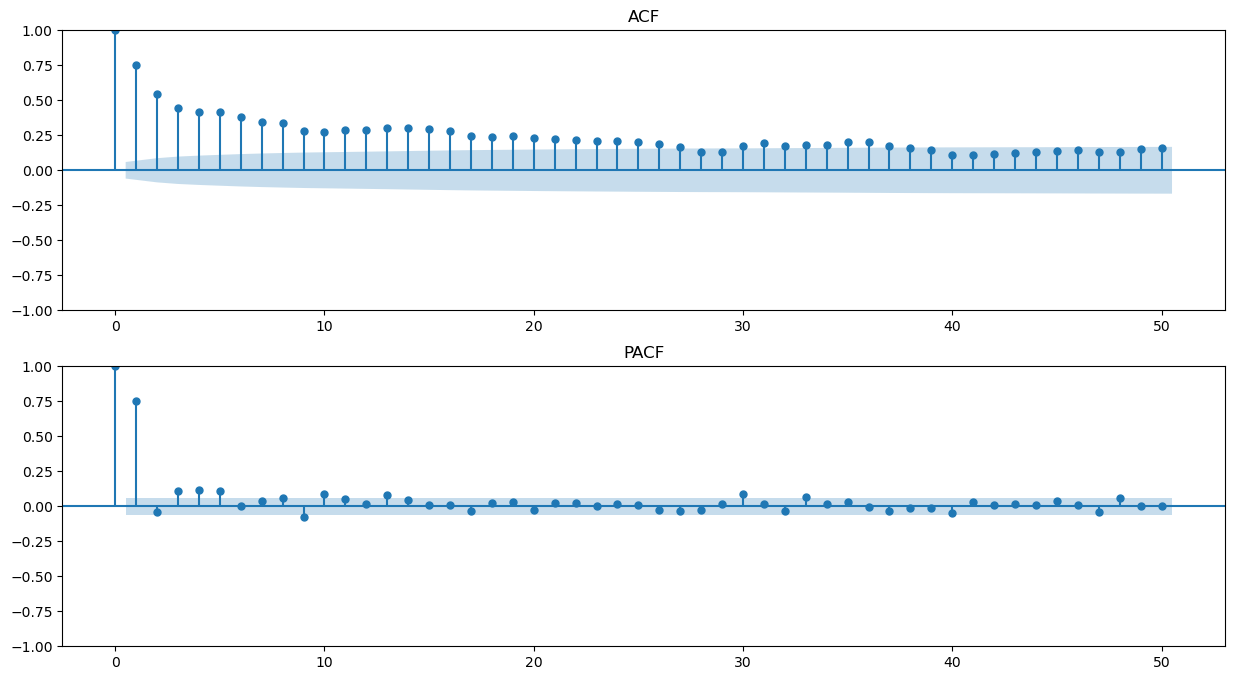

In [15]:
plot_acf_pacf(data['PM2.5'].dropna())


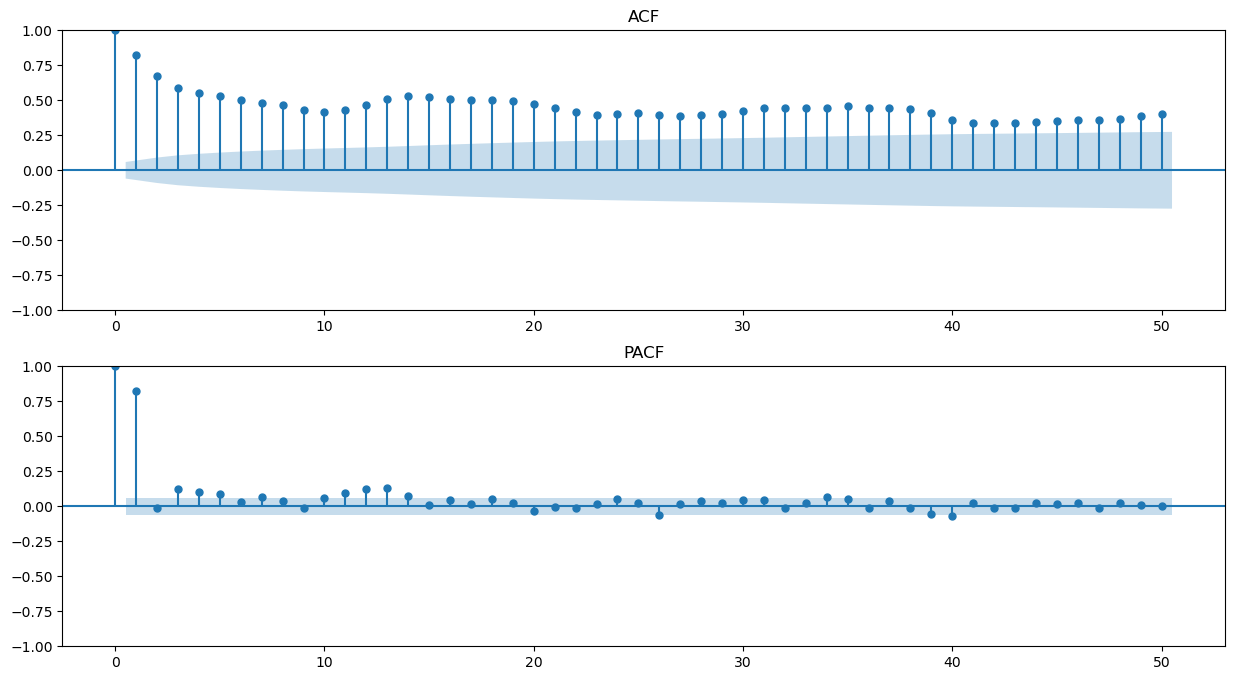

In [16]:
# NO2 için ACF ve PACF grafikleri
plot_acf_pacf(data['NO2'].dropna())

In [17]:
# Eksik değerleri kontrol etme
print(data.isnull().sum())

# Eksik değerleri ortalama ile doldurma
#df.fillna(df.mean(), inplace=True)

PM10     0
PM2.5    0
NO2      0
dtype: int64


In [18]:
## PM10 İÇİN BEST MODEL BULMA VE PERFORMANS ÖLÇME







In [19]:
def evaluate_arima_model(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fitPM10 = model.fit()
    aic = model_fitPM10.aic
    bic = model_fitPM10.bic
    return aic, bic

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_model(data['PM10'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=10852.348 BIC=10862.347
ARIMA(0, 0, 1) AIC=10260.160 BIC=10275.158
ARIMA(0, 0, 2) AIC=10130.766 BIC=10150.764
ARIMA(0, 0, 3) AIC=10086.851 BIC=10111.848
ARIMA(0, 0, 4) AIC=10082.649 BIC=10112.646
ARIMA(0, 1, 0) AIC=10220.852 BIC=10225.850
ARIMA(0, 1, 1) AIC=10215.386 BIC=10225.383
ARIMA(0, 1, 2) AIC=10072.669 BIC=10087.664
ARIMA(0, 1, 3) AIC=10019.280 BIC=10039.274
ARIMA(0, 1, 4) AIC=10007.981 BIC=10032.974
ARIMA(0, 2, 0) AIC=11031.386 BIC=11036.383
ARIMA(0, 2, 1) AIC=10221.535 BIC=10231.530
ARIMA(0, 2, 2) AIC=10216.318 BIC=10231.310
ARIMA(0, 2, 3) AIC=10076.642 BIC=10096.632
ARIMA(0, 2, 4) AIC=10024.273 BIC=10049.261
ARIMA(1, 0, 0) AIC=10066.905 BIC=10081.903
ARIMA(1, 0, 1) AIC=10054.359 BIC=10074.357
ARIMA(1, 0, 2) AIC=10044.922 BIC=10069.919
ARIMA(1, 0, 3) AIC=10026.373 BIC=10056.369
ARIMA(1, 0, 4) AIC=10016.506 BIC=10051.502
ARIMA(1, 1, 0) AIC=10219.286 BIC=10229.283
ARIMA(1, 1, 1) AIC=10034.586 BIC=10049.581
ARIMA(1, 1, 2) AIC=10005.652 BIC=10025.646
ARIMA(1, 1,

In [20]:
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train = data[:train_size]
val = data[train_size:train_size+val_size]
test = data[train_size+val_size:]

In [21]:
model = ARIMA(train['PM10'], order=(3, 1, 4))
model_fitPM10 = model.fit()

In [22]:
val_predictions = model_fitPM10.forecast(steps=len(val))
val_predictions = pd.Series(val_predictions, index=val.index)

if val['PM10'].isnull().values.any():
    val['PM10'] = val['PM10'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictions.isnull().values.any():
    val_predictions = val_predictions.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_val = mean_absolute_error(val['PM10'], val_predictions)
mse_val = mean_squared_error(val['PM10'], val_predictions)
rmse_val = np.sqrt(mse_val)

print(f'Validation MAE: {mae_val}')
print(f'Validation MSE: {mse_val}')
print(f'Validation RMSE: {rmse_val}')

Validation MAE: 28.40892110619591
Validation MSE: 1519.4143973136859
Validation RMSE: 38.97966645975419


In [23]:
# Test seti üzerinde tahmin yapma
test_predictions = model_fitPM10.forecast(steps=len(test))
test_predictions = pd.Series(test_predictions, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['PM10'].isnull().values.any():
    test['PM10'] = test['PM10'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictions.isnull().values.any():
    test_predictions = test_predictions.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_test = mean_absolute_error(test['PM10'], test_predictions)
mse_test = mean_squared_error(test['PM10'], test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

Test MAE: 28.314351776240702
Test MSE: 1699.6163069919414
Test RMSE: 41.226403032425004


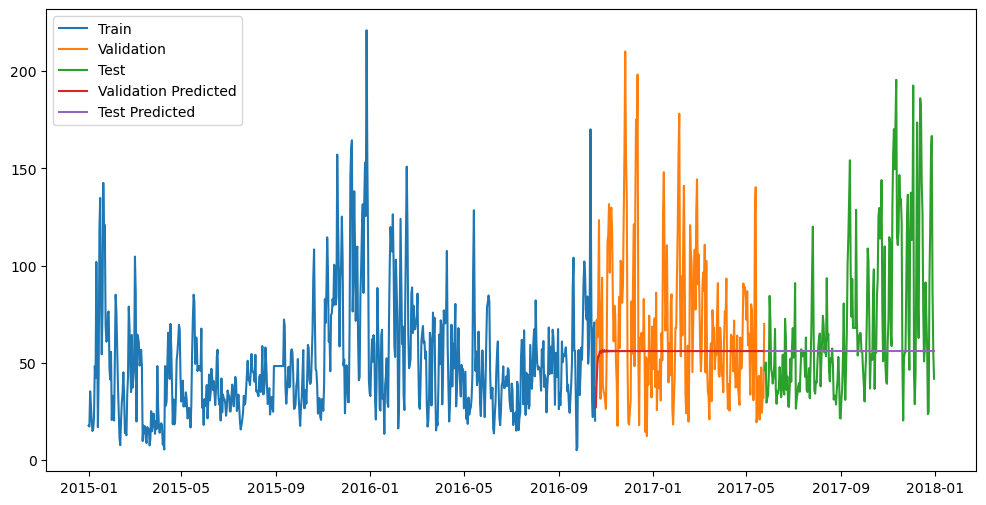

In [24]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['PM10'], label='Train')
plt.plot(val['PM10'], label='Validation')
plt.plot(test['PM10'], label='Test')
plt.plot(val_predictions, label='Validation Predicted')
plt.plot(test_predictions, label='Test Predicted')
plt.legend()
plt.show()

In [25]:
best_modelPM10 = ARIMA(data['PM10'], order=(3, 1, 4))
model_fitPM10 = best_modelPM10.fit()

print(model_fitPM10.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1096
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -4987.698
Date:                Tue, 11 Jun 2024   AIC                           9991.397
Time:                        13:50:11   BIC                          10031.385
Sample:                    01-01-2015   HQIC                         10006.528
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8772      0.038    -22.850      0.000      -0.952      -0.802
ar.L2         -0.3854      0.052     -7.414      0.000      -0.487      -0.283
ar.L3          0.4429      0.041     10.883      0.0

In [26]:
n_periods = 4  # 4 adım ileriye tahmin
forecast = model_fitPM10.forecast(steps=n_periods)
forecast

2018-01-01    56.310391
2018-01-02    80.185997
2018-01-03    84.724368
2018-01-04    86.298911
Freq: D, Name: predicted_mean, dtype: float64

In [27]:
# Güven aralıklarını hesaplama
conf_int = model_fitPM10.get_forecast(steps=n_periods).conf_int()

In [28]:
# Tahminleri DataFrame'e çevirme
forecast_index = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=forecast_index)

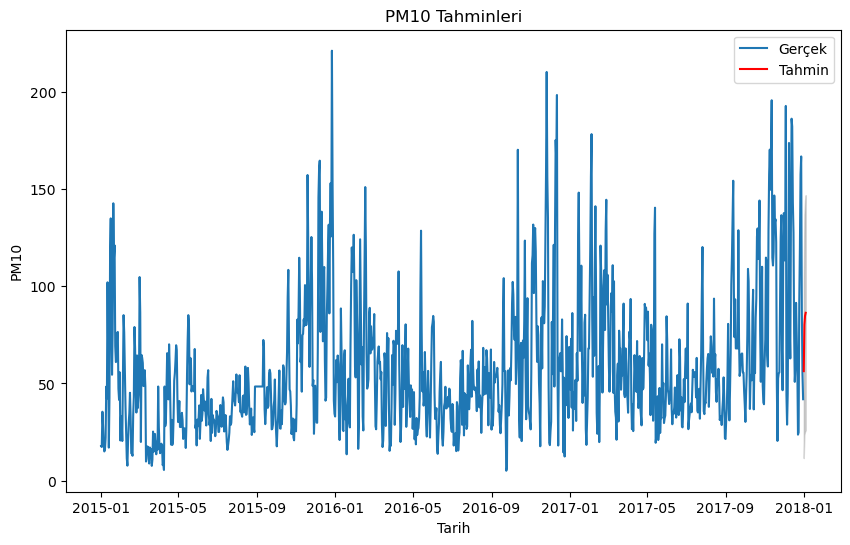

In [29]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['PM10'], label='Gerçek')
plt.plot(forecast_series.index, forecast_series, color='red', label='Tahmin')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('PM10')
plt.title('PM10 Tahminleri')
plt.legend()
plt.show()

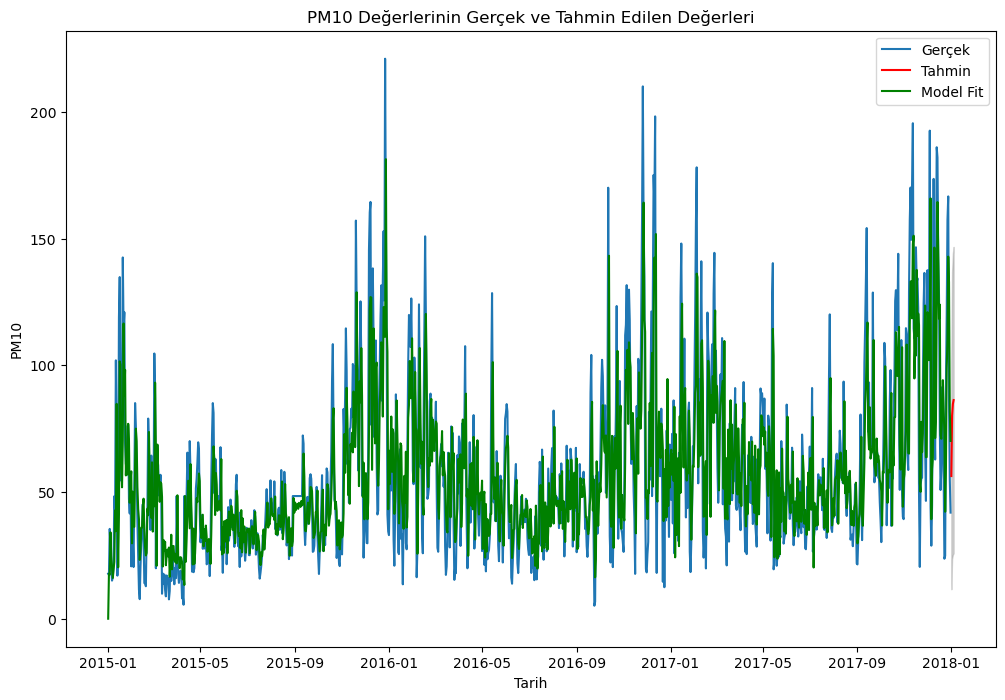

In [30]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['PM10'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_series.index, forecast_series, color='red', label='Tahmin')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_values = model_fitPM10.fittedvalues
plt.plot(fitted_values.index, fitted_values, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('PM10')
plt.title('PM10 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()

In [31]:
# PM2.5 İÇİN TÜM İLERLEMELER  





In [32]:
def evaluate_arima_modelPM25(data, arima_order):
    modelPM25 = ARIMA(data, order=arima_order)
    model_fitPM25 = modelPM25.fit()
    aic = model_fitPM25.aic
    bic = model_fitPM25.bic
    return aic, bic

p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 3)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_modelPM25(data['PM2.5'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=8621.048 BIC=8631.046
ARIMA(0, 0, 1) AIC=8008.882 BIC=8023.880
ARIMA(0, 0, 2) AIC=7842.125 BIC=7862.123
ARIMA(0, 1, 0) AIC=7847.675 BIC=7852.673
ARIMA(0, 1, 1) AIC=7832.125 BIC=7842.122
ARIMA(0, 1, 2) AIC=7716.137 BIC=7731.133
ARIMA(0, 2, 0) AIC=8694.829 BIC=8699.827
ARIMA(0, 2, 1) AIC=7850.537 BIC=7860.532
ARIMA(0, 2, 2) AIC=7835.382 BIC=7850.375
ARIMA(0, 3, 0) AIC=9848.836 BIC=9853.832
ARIMA(0, 3, 1) AIC=8696.882 BIC=8706.875
ARIMA(0, 3, 2) AIC=7861.740 BIC=7876.730
ARIMA(1, 0, 0) AIC=7713.162 BIC=7728.160
ARIMA(1, 0, 1) AIC=7712.953 BIC=7732.951
ARIMA(1, 0, 2) AIC=7692.368 BIC=7717.365
ARIMA(1, 1, 0) AIC=7840.601 BIC=7850.598
ARIMA(1, 1, 1) AIC=7679.051 BIC=7694.046
ARIMA(1, 1, 2) AIC=7666.094 BIC=7686.088
ARIMA(1, 2, 0) AIC=8452.864 BIC=8462.860
ARIMA(1, 2, 1) AIC=7843.617 BIC=7858.610
ARIMA(1, 2, 2) AIC=7853.064 BIC=7873.054
ARIMA(1, 3, 0) AIC=9309.285 BIC=9319.278
ARIMA(1, 3, 1) AIC=8455.879 BIC=8470.869
ARIMA(1, 3, 2) AIC=7855.457 BIC=7875.444
ARIMA(2, 0, 0) A

In [33]:
modelPM25 = ARIMA(train['PM2.5'], order=(3, 1, 2))
model_fitPM25 = modelPM25.fit()

In [34]:
val_predictionsPM25 = model_fitPM25.forecast(steps=len(val))
val_predictionsPM25 = pd.Series(val_predictionsPM25, index=val.index)

if val['PM2.5'].isnull().values.any():
    val['PM2.5'] = val['PM2.5'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictionsPM25.isnull().values.any():
    val_predictionsPM25 = val_predictionsPM25.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_valPM25 = mean_absolute_error(val['PM2.5'], val_predictionsPM25)
mse_valPM25 = mean_squared_error(val['PM2.5'], val_predictionsPM25)
rmse_valPM25 = np.sqrt(mse_valPM25)

print(f'Validation MAE: {mae_valPM25}')
print(f'Validation MSE: {mse_valPM25}')
print(f'Validation RMSE: {rmse_valPM25}')

Validation MAE: 16.199514814830344
Validation MSE: 456.23358015965783
Validation RMSE: 21.359625000445533


In [35]:
# Test seti üzerinde tahmin yapma
test_predictionsPM25 = model_fitPM25.forecast(steps=len(test))
test_predictionsPM25 = pd.Series(test_predictionsPM25, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['PM2.5'].isnull().values.any():
    test['PM2.5'] = test['PM2.5'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictionsPM25.isnull().values.any():
    test_predictionsPM25 = test_predictionsPM25.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_testPM25 = mean_absolute_error(test['PM2.5'], test_predictionsPM25)
mse_testPM25 = mean_squared_error(test['PM2.5'], test_predictionsPM25)
rmse_testPM25 = np.sqrt(mse_testPM25)

print(f'Test MAE: {mae_testPM25}')
print(f'Test MSE: {mse_testPM25}')
print(f'Test RMSE: {rmse_testPM25}')

Test MAE: 16.532148402741015
Test MSE: 466.9038390147976
Test RMSE: 21.607957770571414


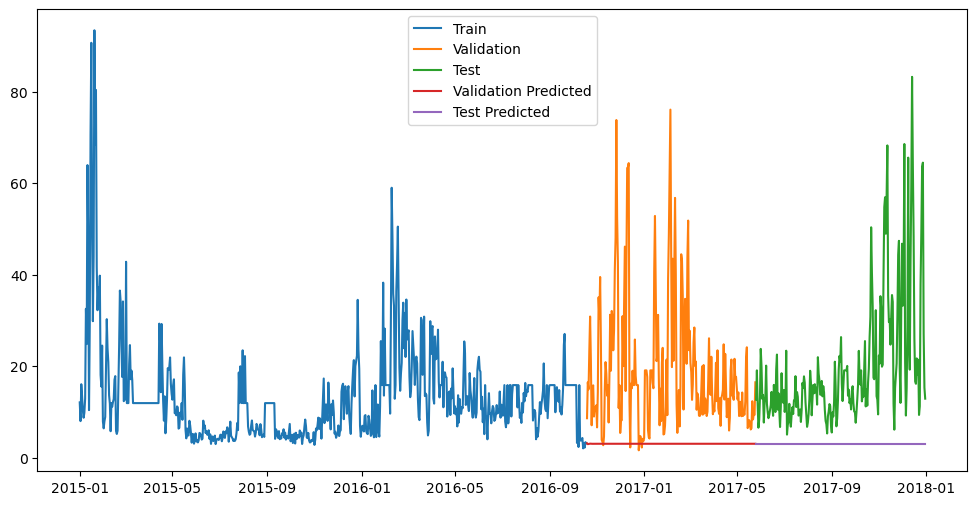

In [36]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['PM2.5'], label='Train')
plt.plot(val['PM2.5'], label='Validation')
plt.plot(test['PM2.5'], label='Test')
plt.plot(val_predictionsPM25, label='Validation Predicted')
plt.plot(test_predictionsPM25, label='Test Predicted')
plt.legend()
plt.show()

In [37]:
best_modePM25 = ARIMA(data['PM2.5'], order=(3, 1, 2))
model_fitPM25 = best_modePM25.fit()
print(model_fitPM25.summary())      #BURADA OVERFİTTİNG DURUMU OLDUĞU İÇİN EN İYİ MODEL SEÇİMİ DEĞİŞİYOR

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1096
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3826.884
Date:                Tue, 11 Jun 2024   AIC                           7665.768
Time:                        13:50:58   BIC                           7695.759
Sample:                    01-01-2015   HQIC                          7677.116
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3501      0.167      8.103      0.000       1.024       1.677
ar.L2         -0.5995      0.115     -5.203      0.000      -0.825      -0.374
ar.L3          0.1316      0.021      6.298      0.0

In [38]:
n_periods = 12  # 4 adım ileriye tahmin
forecastPM25 = model_fitPM25.forecast(steps=n_periods)
forecastPM25

2018-01-01    21.352658
2018-01-02    26.698997
2018-01-03    28.520700
2018-01-04    28.889892
2018-01-05    28.999696
2018-01-06    29.166315
2018-01-07    29.374025
2018-01-08    29.569019
2018-01-09    29.729688
2018-01-10    29.857043
2018-01-11    29.958324
2018-01-12    30.039857
Freq: D, Name: predicted_mean, dtype: float64

In [39]:
# Güven aralıklarını hesaplama
conf_intPM25 = model_fitPM25.get_forecast(steps=n_periods).conf_int()

In [40]:
# Tahminleri DataFrame'e çevirme
forecast_indexPM25 = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_seriesPM25 = pd.Series(forecastPM25, index=forecast_indexPM25)
lower_seriesPM25 = pd.Series(conf_intPM25.iloc[:, 0], index=forecast_indexPM25)
upper_seriesPM25 = pd.Series(conf_intPM25.iloc[:, 1], index=forecast_indexPM25)

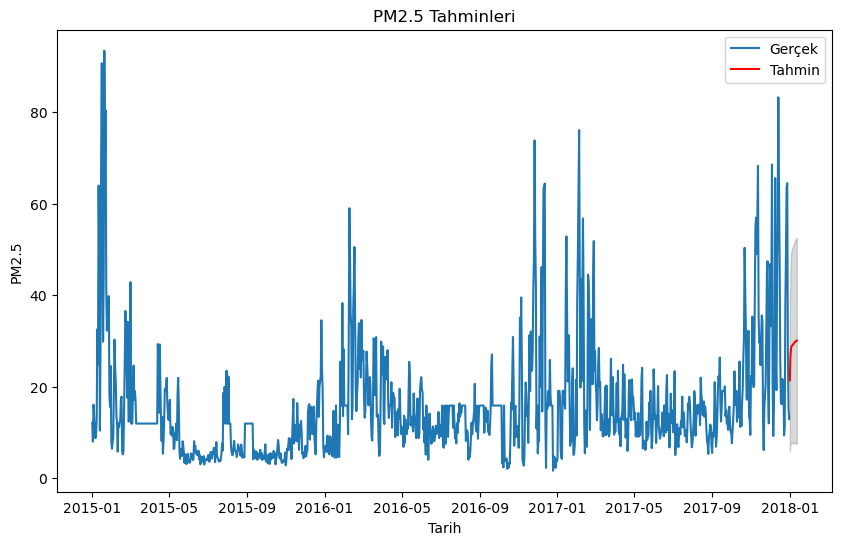

In [41]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['PM2.5'], label='Gerçek')
plt.plot(forecast_seriesPM25.index, forecast_seriesPM25, color='red', label='Tahmin')
plt.fill_between(lower_seriesPM25.index, 
                 lower_seriesPM25, 
                 upper_seriesPM25, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('PM2.5')
plt.title('PM2.5 Tahminleri')
plt.legend()
plt.show()

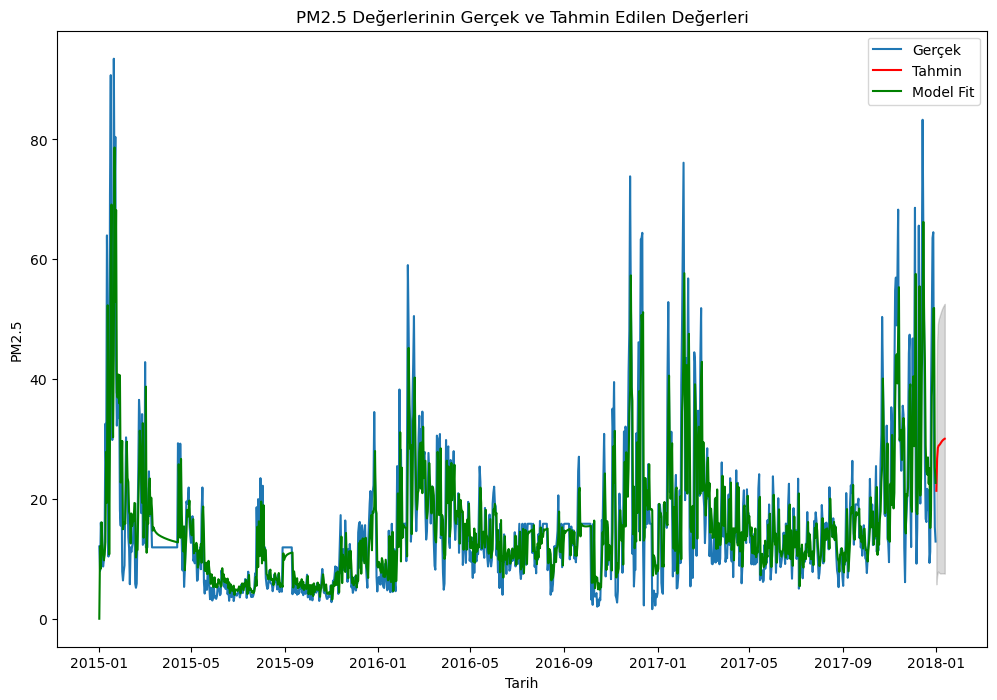

In [42]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['PM2.5'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_seriesPM25.index, forecast_seriesPM25, color='red', label='Tahmin')
plt.fill_between(lower_seriesPM25.index, lower_seriesPM25, upper_seriesPM25, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_valuesPM25 = model_fitPM25.fittedvalues
plt.plot(fitted_valuesPM25.index, fitted_valuesPM25, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('PM2.5')
plt.title('PM2.5 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()

In [43]:
# NO2 İÇİN TÜM İLERLEMELER  








In [44]:
def evaluate_arima_modelNO2(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fitNO2 = model.fit()
    aic = model_fitNO2.aic
    bic = model_fitNO2.bic
    return aic, bic

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_modelNO2(data['NO2'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=9479.088 BIC=9489.087
ARIMA(0, 0, 1) AIC=8742.142 BIC=8757.140
ARIMA(0, 0, 2) AIC=8495.248 BIC=8515.246
ARIMA(0, 0, 3) AIC=8390.150 BIC=8415.147
ARIMA(0, 0, 4) AIC=8356.464 BIC=8386.461
ARIMA(0, 1, 0) AIC=8336.034 BIC=8341.032
ARIMA(0, 1, 1) AIC=8326.046 BIC=8336.043
ARIMA(0, 1, 2) AIC=8240.699 BIC=8255.695
ARIMA(0, 1, 3) AIC=8191.000 BIC=8210.994
ARIMA(0, 1, 4) AIC=8176.571 BIC=8201.564
ARIMA(0, 2, 0) AIC=9169.958 BIC=9174.955
ARIMA(0, 2, 1) AIC=8338.446 BIC=8348.441
ARIMA(0, 2, 2) AIC=8328.750 BIC=8343.743
ARIMA(0, 2, 3) AIC=8245.017 BIC=8265.008
ARIMA(0, 2, 4) AIC=8196.801 BIC=8221.789
ARIMA(1, 0, 0) AIC=8245.949 BIC=8260.947
ARIMA(1, 0, 1) AIC=8247.758 BIC=8267.755
ARIMA(1, 0, 2) AIC=8222.811 BIC=8247.808
ARIMA(1, 0, 3) AIC=8195.831 BIC=8225.827
ARIMA(1, 0, 4) AIC=8183.164 BIC=8218.160
ARIMA(1, 1, 0) AIC=8331.197 BIC=8341.194
ARIMA(1, 1, 1) AIC=8184.151 BIC=8199.147
ARIMA(1, 1, 2) AIC=8170.923 BIC=8190.917
ARIMA(1, 1, 3) AIC=8172.876 BIC=8197.869
ARIMA(1, 1, 4) A

In [45]:
model = ARIMA(train['NO2'], order=(1, 1, 2))
model_fitNO2 = model.fit()

In [46]:
val_predictionsNO2 = model_fitNO2.forecast(steps=len(val))
val_predictionsNO2 = pd.Series(val_predictionsNO2, index=val.index)

if val['NO2'].isnull().values.any():
    val['NO2'] = val['NO2'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictionsNO2.isnull().values.any():
    val_predictionsNO2 = val_predictionsNO2.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_valNO2 = mean_absolute_error(val['NO2'], val_predictionsNO2)
mse_valNO2 = mean_squared_error(val['NO2'], val_predictionsNO2)
rmse_valNO2 = np.sqrt(mse_valNO2)

print(f'Validation MAE: {mae_valNO2}')
print(f'Validation MSE: {mse_valNO2}')
print(f'Validation RMSE: {rmse_valNO2}')

Validation MAE: 13.467762234730765
Validation MSE: 285.4662743444453
Validation RMSE: 16.895747226578802


In [47]:
# Test seti üzerinde tahmin yapma
test_predictionsNO2 = model_fitNO2.forecast(steps=len(test))
test_predictionsNO2 = pd.Series(test_predictionsNO2, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['NO2'].isnull().values.any():
    test['NO2'] = test['NO2'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictionsNO2.isnull().values.any():
    test_predictionsNO2 = test_predictionsNO2.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_testNO2 = mean_absolute_error(test['NO2'], test_predictionsNO2)
mse_testNO2 = mean_squared_error(test['NO2'], test_predictionsNO2)
rmse_testNO2 = np.sqrt(mse_testNO2)

print(f'Test MAE: {mae_testNO2}')
print(f'Test MSE: {mse_testNO2}')
print(f'Test RMSE: {rmse_testNO2}')

Test MAE: 13.45000464104055
Test MSE: 249.73206097863775
Test RMSE: 15.802913053568249


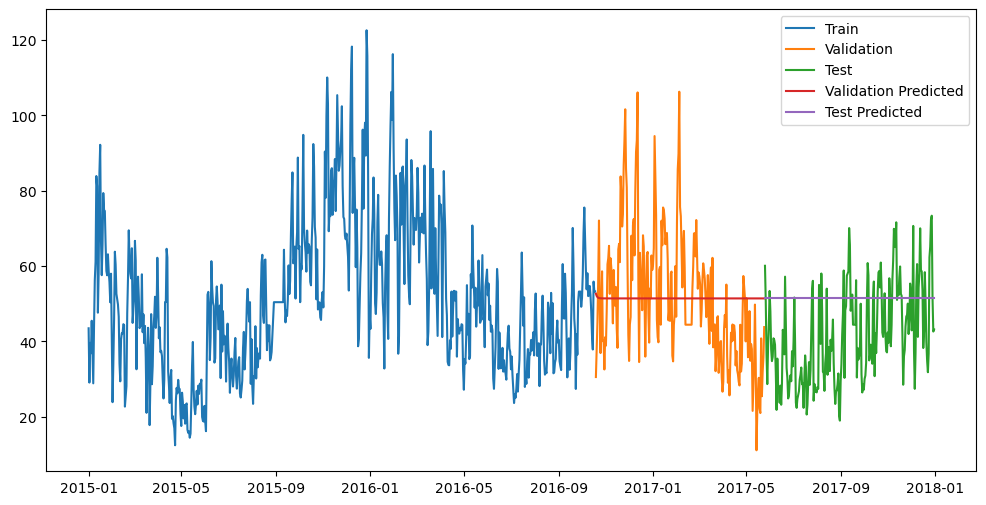

In [48]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['NO2'], label='Train')
plt.plot(val['NO2'], label='Validation')
plt.plot(test['NO2'], label='Test')
plt.plot(val_predictionsNO2, label='Validation Predicted')
plt.plot(test_predictionsNO2, label='Test Predicted')
plt.legend()
plt.show()

In [49]:
best_modelNO2 = ARIMA(data['NO2'], order=(1, 1, 2))
model_fitNO2 = best_modelNO2.fit()
print(model_fitNO2.summary())  

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1096
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4081.461
Date:                Tue, 11 Jun 2024   AIC                           8170.923
Time:                        13:54:24   BIC                           8190.917
Sample:                    01-01-2015   HQIC                          8178.488
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5317      0.042     12.779      0.000       0.450       0.613
ma.L1         -0.7542      0.048    -15.865      0.000      -0.847      -0.661
ma.L2         -0.1752      0.039     -4.515      0.0

In [50]:
n_periods = 12  # 4 adım ileriye tahmin
forecastNO2 = model_fitNO2.forecast(steps=n_periods)
forecastNO2

2018-01-01    46.129096
2018-01-02    48.050261
2018-01-03    49.071741
2018-01-04    49.614859
2018-01-05    49.903634
2018-01-06    50.057176
2018-01-07    50.138813
2018-01-08    50.182220
2018-01-09    50.205299
2018-01-10    50.217570
2018-01-11    50.224095
2018-01-12    50.227564
Freq: D, Name: predicted_mean, dtype: float64

In [51]:
# Güven aralıklarını hesaplama
conf_intNO2 = model_fitNO2.get_forecast(steps=n_periods).conf_int()

In [52]:
# Tahminleri DataFrame'e çevirme
forecast_indexNO2 = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_seriesNO2 = pd.Series(forecastNO2, index=forecast_indexNO2)
lower_seriesNO2 = pd.Series(conf_intNO2.iloc[:, 0], index=forecast_indexNO2)
upper_seriesNO2 = pd.Series(conf_intNO2.iloc[:, 1], index=forecast_indexNO2)

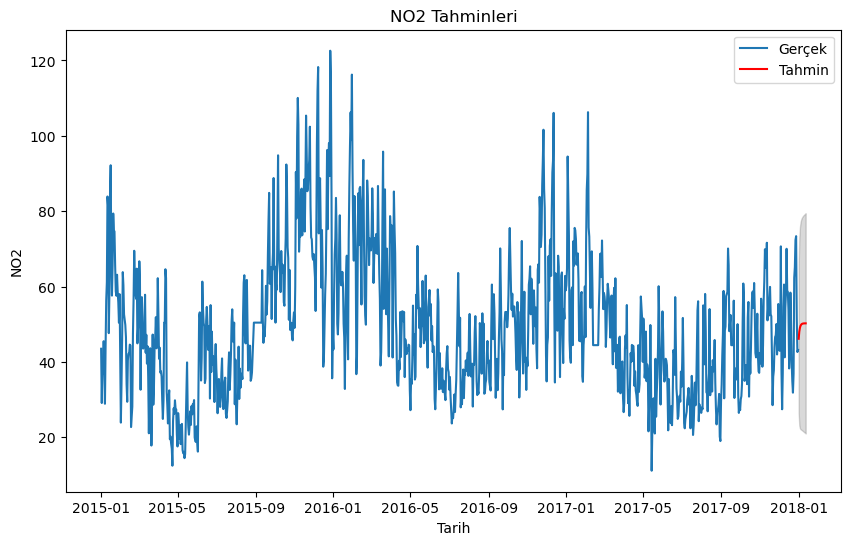

In [53]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['NO2'], label='Gerçek')
plt.plot(forecast_seriesNO2.index, forecast_seriesNO2, color='red', label='Tahmin')
plt.fill_between(lower_seriesNO2.index, 
                 lower_seriesNO2, 
                 upper_seriesNO2, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('NO2')
plt.title('NO2 Tahminleri')
plt.legend()
plt.show()

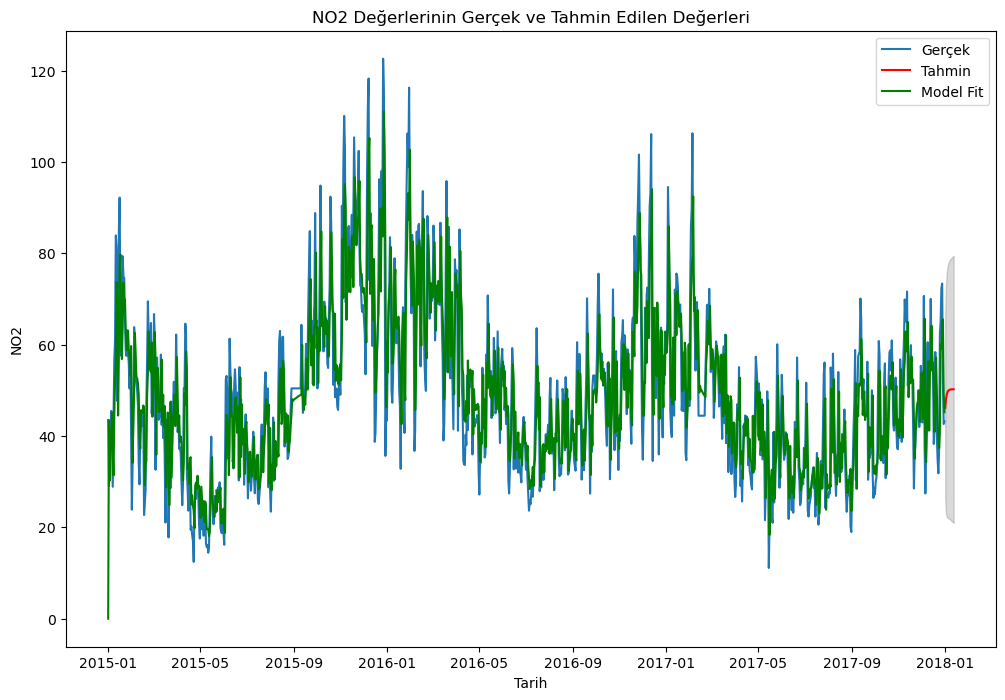

In [54]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['NO2'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_seriesNO2.index, forecast_seriesNO2, color='red', label='Tahmin')
plt.fill_between(lower_seriesNO2.index, lower_seriesNO2, upper_seriesNO2, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_valuesNO2 = model_fitNO2.fittedvalues
plt.plot(fitted_valuesNO2.index, fitted_valuesNO2, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('NO2')
plt.title('NO2 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()